# Power Demand : anomaly detector and corrector (ADC)

This notebook analyzes power demand data in order to detect and correct anomalies (outliers & missing data)

NB: the power data is retrieved from an sqlite db, but the ADC can be applied to any other source.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import sqlite3
import calendar

In [2]:
# load the power load data into pandas dataframes, and convert sqlite TIMESTAMP into python datetime
conn = sqlite3.connect('power-data.db')
region_map = pd.read_sql_query("SELECT region, super_region from region_map", conn)
region_load = pd.read_sql_query("SELECT region, date, load from region_load", conn).astype({'date': 'datetime64[ns]'}) 
conn.close()

Each region belons to a super-region

In [3]:
region_map

,region,super_region
0,Capital,Upstate
1,Central,Upstate
2,Dunwoodie,Upstate
3,Genesee,Upstate
4,Hudson Valley,Downstate
5,Long Island,Downstate
6,Millwood,Upstate
7,Mohawk Valley,Upstate
8,New York City,Downstate
9,North,Upstate


Some data points are missing (NaN)

In [4]:
region_load

,region,date,load
0,Capital,2018-06-20,1495.583333
1,Capital,2018-06-21,1470.291667
2,Capital,2018-06-22,1422.458333
3,Capital,2018-06-23,1357.291667
4,Capital,2018-06-24,1301.416667
...,...,...,...
18211,West,2022-12-27,NaN
18212,West,2022-12-28,1595.458333
18213,West,2022-12-29,1571.208333
18214,West,2022-12-30,1554.958333


## Total load by super-region

Regions load data aggregated by super-regions.
To do so, a DataFrame is created with total load (sum) by day, across each super-region.
The dataframe is then reformated to get a column per super-region.
Then both time series are plotted on a single axis.

The function that performs the aggregation.

In [5]:
# The left join is to ensure that we have all the super-regions # in the event
# that there is no data for all the regions in a given super-region

def get_super_region_load(region_map, region_load) -> pd.DataFrame:
    super_region_load = \
        pd.merge(
            region_map,
            region_load,
            how="left",
            on=["region"]
        )[['super_region', 'date', 'load']].\
        groupby(['super_region', 'date']).\
        sum(min_count=1).\
        sort_values(by = ['super_region', 'date']).\
        unstack('super_region').\
        droplevel(0,1)
    return super_region_load

In [6]:
super_region_load = get_super_region_load(region_map, region_load)
super_region_load

super_region,Downstate,Upstate
date,,
2018-06-20,11688.208333,8735.041667
2018-06-21,11518.041667,8751.625000
2018-06-22,10890.208333,8456.250000
2018-06-23,8899.375000,7988.750000
2018-06-24,-4320.127150,7845.916667
...,...,...
2022-12-27,9551.666667,7613.666667
2022-12-28,9101.458333,8877.333333
2022-12-29,8710.416667,8343.583333


The plot.

It becomes obvious that the data contains a lot of outliers.

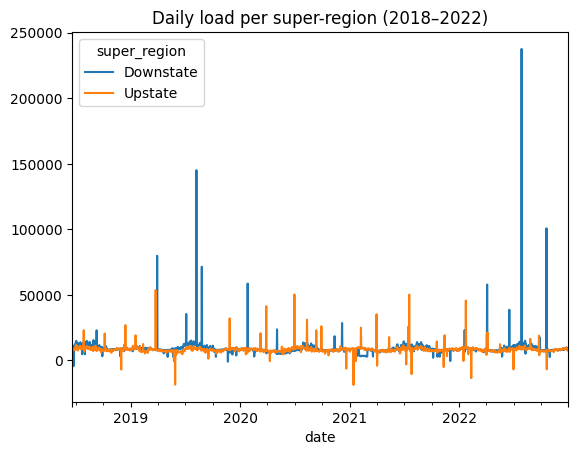

In [7]:
super_region_load.plot(title = "Daily load per super-region (2018–2022)");

#### NB: Total load by super-region directly in SQL

It is possible to directly calculate the total load by date & super-region in SQL.
The results are then ordered by region/date.

In [8]:
conn = sqlite3.connect('power-data.db')

print("\nregion_map : ------------------------------------------------------\n")
print(pd.read_sql_query("SELECT * FROM region_map", conn))

print("\nregion_load  : ----------------------------------------------------\n")
print(pd.read_sql_query("SELECT * FROM region_load", conn))

print("\njoined data  : ----------------------------------------------------\n")
query = """
    SELECT     rm.super_region, rl.date, SUM(rl.load) AS load
    FROM       region_map AS rm
    LEFT JOIN  region_load AS rl
    ON         rm.region = rl.region
    GROUP BY   super_region, date
    ORDER BY   super_region, date
"""
print(pd.read_sql_query(query, conn))

print("\njoined data  : ----------------------------------------------------\n")
query2 = """
    SELECT     rl.date,
               SUM(CASE WHEN rm.super_region = 'Downstate' THEN rl.load END) Downstate,
               SUM(CASE WHEN rm.super_region = 'Upstate' THEN rl.load END) Upstate
    FROM       region_map AS rm
    LEFT JOIN  region_load AS rl
    ON         rm.region = rl.region
    GROUP BY   date
    ORDER BY   rm.region, date
"""
print(pd.read_sql_query(query2, conn))

conn.close()



region_map : ------------------------------------------------------

    index         region super_region
0       0        Capital      Upstate
1       1        Central      Upstate
2       2      Dunwoodie      Upstate
3       3        Genesee      Upstate
4       4  Hudson Valley    Downstate
5       5    Long Island    Downstate
6       6       Millwood      Upstate
7       7  Mohawk Valley      Upstate
8       8  New York City    Downstate
9       9          North      Upstate
10     10           West      Upstate

region_load  : ----------------------------------------------------

       index   region                 date         load
0          0  Capital  2018-06-20 00:00:00  1495.583333
1          1  Capital  2018-06-21 00:00:00  1470.291667
2          2  Capital  2018-06-22 00:00:00  1422.458333
3          3  Capital  2018-06-23 00:00:00  1357.291667
4          4  Capital  2018-06-24 00:00:00  1301.416667
...      ...      ...                  ...          ...
18211  18211

## Seasonal plot

A seasonal plot is a clean way of looking at the entire time series at once, with each year of data in context of the other years.
It allows to inspect time series a little deeper.
A seasonal DataFrame has the *day of year* as  index, the *year* as columns, and the load by year/day of year as values.
The plot is created for one of the super-region only.

The function that create the seasonal dataframe.

In [9]:
def get_downstate_seasonal(super_region_load) -> pd.DataFrame:
    super_region_load_no_index = super_region_load.reset_index()
    downstate_load = \
        super_region_load_no_index.\
        assign(
            day_of_year = super_region_load_no_index['date'].dt.dayofyear,
            year = super_region_load_no_index['date'].dt.year
            ).\
        drop(columns = ['date', 'Upstate']).\
        rename(columns = {'Downstate': 'load'})

    downstate_seasonal_load = \
        downstate_load.pivot(\
                index = 'day_of_year',
                columns = 'year',
                values = 'load')
    return downstate_seasonal_load


The seasonal dataframe.

In [10]:
downstate_seasonal_load = get_downstate_seasonal(super_region_load)
print(downstate_seasonal_load.to_string())

year                 2018           2019          2020          2021           2022
day_of_year                                                                        
1                     NaN    8067.458333   8308.958333   8203.708333    7621.708333
2                     NaN    8811.750000   8862.500000   7916.208333    7532.000000
3                     NaN    9032.375000   8858.666667   8210.000000    8790.458333
4                     NaN    9068.291667   8266.750000   8600.500000    9375.708333
5                     NaN    8471.833333   8155.791667   8678.750000    9206.166667
6                     NaN    8205.541667   8993.041667   8669.875000    8783.333333
7                     NaN    6953.500000   9037.000000   8779.708333    9174.708333
8                     NaN    9309.083333   9111.125000   8930.083333    9146.250000
9                     NaN    8948.166667   9518.000000   8609.458333    8846.791667
10                    NaN    9361.708333   9272.833333   8252.250000    9002

The function tha plots the seasonal dataframe

In [11]:
def plot_downstate(downstate_seasonal_load, period) -> None:
    downstate_seasonal_load.plot(
        kind = 'line',
        xlabel='day_of_year',
        ylabel='load',
        title = f"Seasonal load in super-region Downstate ({period})"
    )

The seasonal plot.

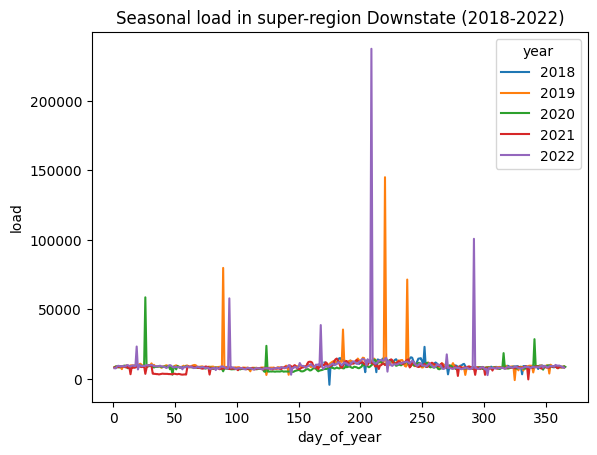

In [12]:
plot_downstate(downstate_seasonal_load, period = "2018-2022")

This chart shows a lot of issues in the data.

1. there are a number of spikes that look like big outliers.  
2. In year 2021, there is a section between day 30 and 60, that is  
preceded by a vertical drop, and followed by a vertical surge, and that  
is much lower than the rest.
3. We can also see some negative values.
4. Almost the first 50% of the data in 2018 are missing

In this state, the data cannot be used, therefore it needs to be cleaned.

NB: 
* Power demand variability comes from the weather so behavior in the different
  regions will be geographically correlated.
* Demand must be zero or positive: so any negative values is an anomaly.
* If a value looks wrong in this context it's probably wrong

## Cleaning: detecting and correcting

The previous aggregated data is not clean: there are a lot of missing and unrealistic values. 

There are a lot of cleaning strategies that can be implemented.
Here the chosen strategy could be used on any king of time series, especially on realtime time series.

#### A. First, look for missing values.

In [13]:
missing_values_count = region_load.groupby(['region']).count()
missing_values_count['missing_date'] = missing_values_count['date'].max() - missing_values_count['date']
missing_values_count['missing_load'] = missing_values_count['date'].max() - missing_values_count['load']
print(missing_values_count.sort_values(by = ['missing_date', 'missing_load']))

missing_load_avg = int(missing_values_count['missing_load'].mean())
print("\naverage # of missing load values : ", missing_load_avg)

n_regions_below_average = len(missing_values_count[missing_values_count['missing_load'] < missing_load_avg])
n_regions = len(region_map)
print("# of regions :", n_regions)
print("# of regions below average :", n_regions_below_average)
print("ratio below average :", int(100*(n_regions_below_average/n_regions)), "%")


               date  load  missing_date  missing_load
region                                               
Millwood       1656  1642             0            14
Genesee        1656  1640             0            16
Dunwoodie      1656  1639             0            17
West           1656  1636             0            20
North          1656  1633             0            23
Hudson Valley  1656  1632             0            24
Mohawk Valley  1656  1623             0            33
Central        1656  1610             0            46
New York City  1656  1610             0            46
Capital        1656  1602             0            54
Long Island    1656  1551             0           105

average # of missing load values :  36
# of regions : 11
# of regions below average : 7
ratio below average : 63 %


All regions have the same number of dates.  
Millwood has the lowest # of missing load values.  
On average, there are 36 missing load values: that means that only 4 regions out of 11 have a relatively high # of missing values.  

---
Possible improvements: check that :
 - there are no duplicates
 - the dates are the same for every region  
   => if this is not the case, then min-date and max-date must  
      be computed to define the same maximum dates interval for  
      all series, and a NaN must be added for each missing date  
      in this interval.

#### B. Handling the outliers and the missing values at once

NB: if we had to deal with data that may arrive at any time, then a time scaling that takes into account the time between 2 values,
should be implemented.
In this particular case, since we deal with daily data, it's not necessary.

This algorithm is designed to detect anomalies in a real-time situation. So it does not have access neither to  
the whole series, nor to the other series.  
It does only use the current value and the past data are summarized by 2 estimators : mean and sigma.  
With each new value, these two estimators are updated.    

There are 7 factors : `lk, uk, lw, uw, alpha_on_mean_return, beta_on_sigma, gamma_on_mean_value.`  
- `lk, uk`: used to define the interval : `[mean - lk*sigma , mean + uk*sigma]`.  
**A value is an outlier if it lands outside this interval.**  
These first 2 parameters are the most important, as they define the tolerance interval.
- `alpha_on_mean_return, beta_on_sigma, gamma_on_mean_value`: are the weights used to compute an average  
between the current value and the corresponding estimators
- `lw, uw` : [winsorizing](https://en.wikipedia.org/wiki/Winsorizing) factors  

Apart from `lk` and `uk`, I have fixed these factors in the exercise. But, in a real situation, they are used  
to fine-tune the efficiency of the algorithm.

In case of an outlier, there is a winsorizing processing that allows the estimators to recover (self-healing).

The algorithm it checks if a value is an anomaly, and at the same time, it returns a corrected value, if it was an anomaly,
or the original value if it was not.
This corrected value is the current estimation of the mean value.  
 
 Replacing by the mean might not be always appropriate, but at least the mean is updated with each new  
 value which ensures that it remains plausible, and close to recent valid values.  
 Moreover, it is possible to extend this algorithm by adding more information, like the current min and max values,  
 or to add other estimators (median) ... and then to use those to find a better replacement value.  

It's important to note that if data are missing from the very beginning they are not replaced. Only the missing data
occurring after 2 valid data can be corrected.  
This decision can off course be discussed. But it is inline with the principle of the algorithm that bases  
the detection on past valid values.

NB:
This algorithm starts to check as soon as it has received 2 values that are not NaN.  
That means that if the first values are outliers, they won't be detected as such.

In [14]:
# NB: Normally, all the helper methods (update_mean, discrete_return ...) that
# are at the end # of the class would be gathered into a separate module or class.

class AnomalyDetector:
    """
    To use with a series by iterating from the 1st element to the last.
    This class computes mean/sigma estimators internally, so it has a state.
    For each new series, a new object of this class must be instanciated

    The main function is check_value: it checks if a value lies inside a band
    formed by this interval : [mean - lk*sigma , mean + uk*sigma], and it returns
    also a replacement value

    lw, and uw are winsorizing factors. Their role is to help the estimators
    to self-heal when an outlier is encountered. In that case, it's using
    the last unchallenged value to recover.
    """
    def __init__(self, lk = 5, uk = 5) -> None:
        # parameters : should be passed as arg to the constructor
        self.lk = lk # lower width of acceptable band
        self.uk = uk # upper width of acceptable band
        self.lw = 5 # winsorizing factor for the lower band
        self.uw = 5 # winsorizing factor for the upper band
        self.alpha_on_mean_return = 0.1 # weighting factor : mean - current return
        self.beta_on_sigma = 0.1 # weighting factor: mean absolute return - absolute return deviation
        self.gamma_on_mean_value = 0.1 # weighting factor : mean - current value

        # estimators (they're also state variables)
        self.previous_unchallenged_value = np.nan # necessary if we keep getting the same value
        self.previous_mean_value = np.nan
        self.previous_mean_return = np.nan
        self.previous_sigma = np.nan

    def check_value(self, value) -> (bool, float):
        """
        1. check if a value is an anomaly, ie if it lies outside the bands
           defined by the interval : [mean - lk*sigma , mean + uk*sigma]
        2. update the current estimation of the state variables (sigma, mean)
        3. returns the original value or a replacement value

        Returns:
            if it is an anomaly :
                return true and the current mean_value estimator
            if not
                return false and the value passed as an argument

            NB: Another possibility would be to directly return the
                original or the corrected value.
                It simplifies the processing, but we wouldn't know anymore
                if the value has been corrected or not
        """

        is_anomaly = False
        unchallenged_value = 0.0
        return_ = 0.0
        mean_value = 0.0
        mean_return = 0.0
        sigma = 0.0

        if np.isnan(value) or value <= 0:
            # In case a NaN (missing value) or an impossible value is encountered 
            # => do nothing, ie do not update any of the estimators
            is_anomaly = True
        else:
            # At least 2 valid values are needed to start computing
            # the estimators
            # Sigma is 1st initialized with NaN, then with 0.
            # Only then, is it possible to start the proper estimation.
            if np.isnan(self.previous_sigma):                
                return_ = 0.0
                mean_value = value
                mean_return = 0.0
                sigma = 0.0
                is_anomaly = False
                unchallenged_value = value
            elif self.previous_sigma == 0.0:
                if value == self.previous_unchallenged_value:
                    return_ = 0.0
                    mean_value = value
                    mean_return = 0.0
                    sigma = 0.0
                    is_anomaly = False
                    unchallenged_value = value
                else:
                    return_ = self.discrete_return(self.previous_unchallenged_value, value)
                    mean_value = self.update_mean(self.gamma_on_mean_value,  self.previous_mean_value, value)
                    mean_return = return_
                    sigma = math.fabs(return_)
                    is_anomaly = False
                    unchallenged_value = value
            else:
                # determine if current value is an anomaly
                return_lower_bound = min([self.previous_sigma, self.bound(self.previous_mean_return, -self.lk, self.previous_sigma)])
                return_upper_bound = max([self.previous_sigma, self.bound(self.previous_mean_return, +self.uk, self.previous_sigma)])

                value_lower_bound = self.previous_mean_value * (1.0 + return_lower_bound)
                value_upper_bound = self.previous_mean_value * (1.0 + return_upper_bound)

                # the value is an anomaly if it lies outside the band
                is_anomaly = (value < value_lower_bound) or (value > value_upper_bound)

                # compute current return as it will be used in every case
                return_ = self.discrete_return(self.previous_unchallenged_value, value)

                # set means/sigma/value to previous values
                mean_value = self.previous_mean_value
                mean_return = self.previous_mean_return
                sigma = self.previous_sigma
                unchallenged_value = self.previous_unchallenged_value

                # update mean/sigma
                if not is_anomaly:
                    mean_value = self.update_mean(self.gamma_on_mean_value, self.previous_mean_value, value)
                    if return_ != 0.0:
                        mean_return = self.update_mean(self.alpha_on_mean_return, self.previous_mean_return, return_)
                        sigma = self.update_sigma(self.beta_on_sigma, self.previous_sigma, self.previous_mean_return, return_)
                    else:
                        mean_return = self.previous_mean_return
                        sigma = self.previous_sigma
                    unchallenged_value = value
                else:
                    # winsorizing : self-healing
                    return_winsorized_lower_bound = self.bound(self.previous_mean_return, -self.lw, self.previous_sigma)
                    return_winsorized_upper_bound = self.bound(self.previous_mean_return, +self.uw, self.previous_sigma)

                    return_prime = 0.0
                    if return_ < return_winsorized_lower_bound:
                        return_prime = return_winsorized_lower_bound
                    elif return_ > return_winsorized_upper_bound:
                        return_prime = return_winsorized_upper_bound
                    else:
                        return_prime = return_

                    value_prime = 0.0
                    if self.is_in_interval(return_, return_winsorized_lower_bound, return_winsorized_upper_bound):
                        value_prime = value
                    else:
                        value_prime = self.previous_unchallenged_value * (1.0 + return_prime)

                    mean_value = self.update_mean(self.gamma_on_mean_value, self.previous_mean_value, value_prime)
                    if return_prime != 0.0:
                        mean_return = self.update_mean(self.alpha_on_mean_return, self.previous_mean_return, return_prime)
                        sigma = self.update_sigma(self.beta_on_sigma, self.previous_sigma, self.previous_mean_return, return_prime)
                    else:
                        mean_return = self.previous_mean_return
                        sigma = self.previous_sigma

            self.previous_mean_value = mean_value
            self.previous_mean_return = mean_return
            self.previous_sigma = sigma
            self.previous_unchallenged_value = unchallenged_value

        # In case of an anomaly or a missing value
        #   => the anomaly will be replaceed by the current mean_value estimator
        #   => that way, the imputated value remains plausible
        if is_anomaly:
            res =  (is_anomaly, self.previous_mean_value)
        else:
            res =  (is_anomaly, value)
        return res

    def update_mean(self, k, mean, current_value) -> float:
        """
            Mean estimator
            k is a weight : 0 <= k <= 1
            
            Returns:
                float: Compute the weighted average between mean and current
        """
        return k * current_value + (1 - k) * mean

    def discrete_return(self, previous_value, current_value) -> float:
        """
        Returns :
            float: the return rate between previous and current
        """
        res = 0.0
        if (previous_value == 0.0) or (current_value == previous_value):
            res = 0.0
        else:
            res = (current_value / previous_value) - 1.0
        return res

    def is_in_interval(self, value, lower_bound, upper_bound) -> bool:
        """
            Returns :
                bool: True if value is between lower and upper, False otherwise
        """
        return (lower_bound <= value) and (value <= upper_bound)

    def bound(self, value, k, sigma) -> float:
        """
            Returns:
                float : the corresponding boundary 
        """
        return value + k * sigma
    
    def update_sigma(self, k, previous_sigma, previous_mean_return, current_return) -> float:
        """
            Sigma estimator

            This is where the sigma is updated with the new value
            NB: if sqrt costs too much, another version with abs could replace this one
            Returns:
                float : the new sigma
        """
        return math.sqrt(k * ((current_return - previous_mean_return) ** 2) + (1.0 - k) * (previous_sigma ** 2))


The algorithm is applied separately to each time series, which are then concatenated.  

In [15]:
def correct_region_load(region_map, region_load) -> pd.DataFrame:
    corrected_region_load = pd.DataFrame()
    for region in region_map['region']:
        one_region_load = region_load[region_load['region'] == region]
        ad = AnomalyDetector(lk = 10, uk = 10)
        one_region_load = one_region_load.assign(check_info = one_region_load['load'].apply(ad.check_value))
        one_region_load[['is_outlier', 'corrected']] = one_region_load['check_info'].apply(pd.Series)
        one_region_load = one_region_load.drop(columns = ['check_info'])
        corrected_region_load = pd.concat([corrected_region_load, one_region_load])
    return corrected_region_load

corrected_region_load = correct_region_load(region_map, region_load)
corrected_region_load[corrected_region_load['is_outlier']]


,region,date,load,is_outlier,corrected
41,Capital,2018-07-31,NaN,True,1631.587527
47,Capital,2018-08-06,NaN,True,1638.071872
75,Capital,2018-09-03,NaN,True,1622.233170
132,Capital,2018-10-30,NaN,True,1287.694222
173,Capital,2018-12-10,4308.763217,True,1409.936727
...,...,...,...,...,...
17802,West,2021-11-13,13064.917598,True,1621.253787
17843,West,2021-12-24,NaN,True,1717.442616
17945,West,2022-04-05,15843.693187,True,1667.669907
18143,West,2022-10-20,-13017.906244,True,1553.398446


Rename the columns and plot again, not corrected (top) and corrected (bottom).

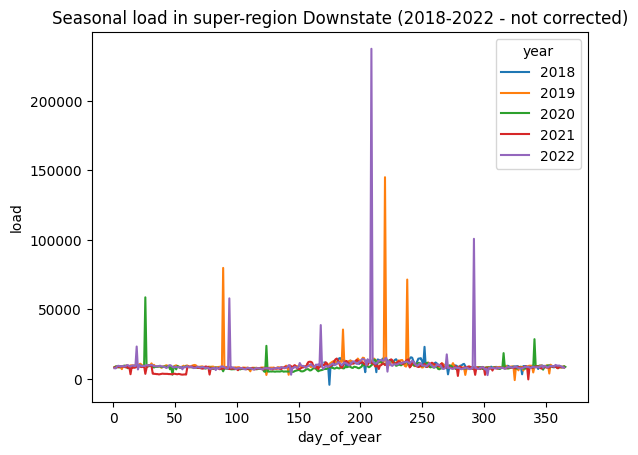

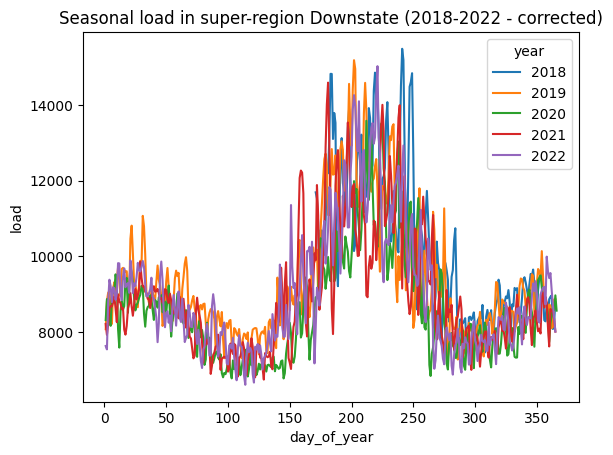

In [16]:
def rename_cols(corrected_region_load) -> pd.DataFrame:
    renamed_corrected_region_load = \
        corrected_region_load.\
        rename(columns = {'load': 'orig'}).\
        rename(columns = {'corrected': 'load'})
    return renamed_corrected_region_load

super_region_load = get_super_region_load(region_map, region_load)
downstate_seasonal_load = get_downstate_seasonal(super_region_load)
plot_downstate(downstate_seasonal_load, period = "2018-2022 - not corrected")

renamed_corrected_region_load = rename_cols(corrected_region_load)
corrected_super_region_load = get_super_region_load(region_map, renamed_corrected_region_load)
corrected_downstate_seasonal_load = get_downstate_seasonal(corrected_super_region_load)
plot_downstate(corrected_downstate_seasonal_load, period = "2018-2022 - corrected")


(below) 2018 not corrected (top) and corrected (bottom)  

NB: As expected, the missing data at the beginning of the year are not corrected.

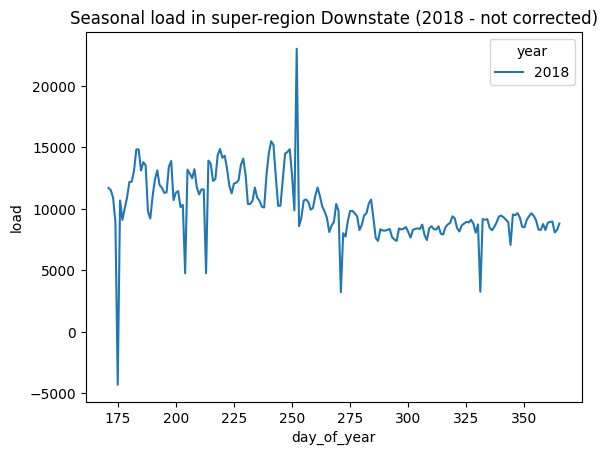

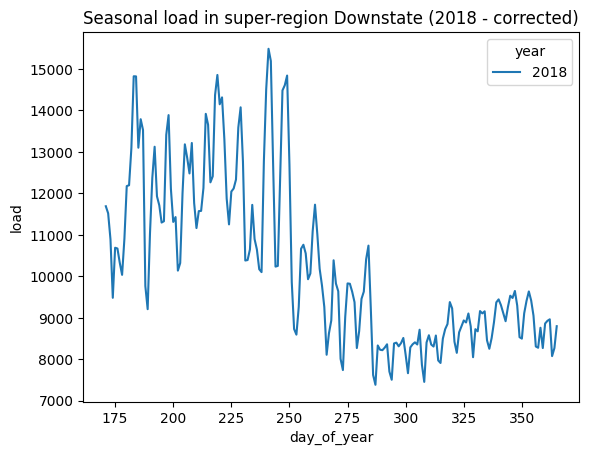

In [17]:
load_2018 = downstate_seasonal_load.drop(columns=[2019, 2020, 2021, 2022])
plot_downstate(load_2018, period = "2018 - not corrected")

corrected_load_2018 = corrected_downstate_seasonal_load.drop(columns=[2019, 2020, 2021, 2022])
plot_downstate(corrected_load_2018, period = "2018 - corrected")

Below: 2020 not corrected (top) and corrected (bottom)

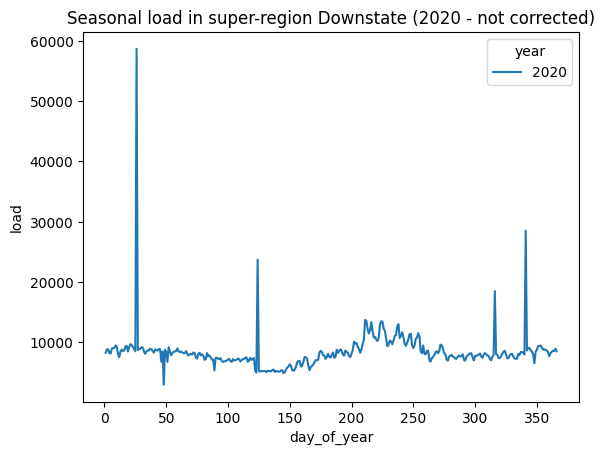

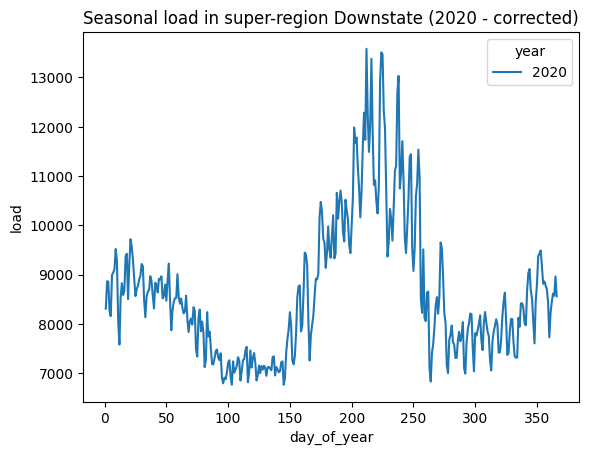

In [18]:
load_2020 = downstate_seasonal_load.drop(columns=[2018, 2019, 2021, 2022])
plot_downstate(load_2020, period = "2020 - not corrected")

corrected_load_2020 = corrected_downstate_seasonal_load.drop(columns=[2018, 2019, 2021, 2022])
plot_downstate(corrected_load_2020, period = "2020 - corrected")